## Spectral Principal Component Analysis on NIRSpec Data 

The aim of this notebook is to implement a **PCA** analysis over the NIRSpec data cubes to get the dimension of the spectral latent space

### Importing python librairies

In [74]:
import numpy as np
import matplotlib.pyplot as plt 
import os, sys
            
from numpy import matlib
from astropy.io import fits 
from astropy.utils.data import get_pkg_data_filename

In [40]:
cube_nirspec170_file = get_pkg_data_filename('nirspec_cube_pos_170lp.fits')

In [41]:
fits.info(cube_nirspec170_file)

Filename: nirspec_cube_pos_170lp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     354   ()      
  1  DATA          1 ImageHDU        90   (133, 259, 3663)   float32   
  2  DQ            1 ImageHDU        89   (133, 259, 3663)   uint8   


### Having a look at the data 

In [42]:
cube_nirspec170_data = fits.getdata(cube_nirspec170_file, ext=1) 

In [43]:
cube_nirspec170_data.shape

(3663, 259, 133)

In [44]:
bands, pix1, pix2 = cube_nirspec170_data.shape
print(f'Number of spectral bands: {bands}\nNumber of pixels: {pix1} x {pix2}')

Number of spectral bands: 3663
Number of pixels: 259 x 133


Text(0.5, 1.0, 'Image at a given wavelength')

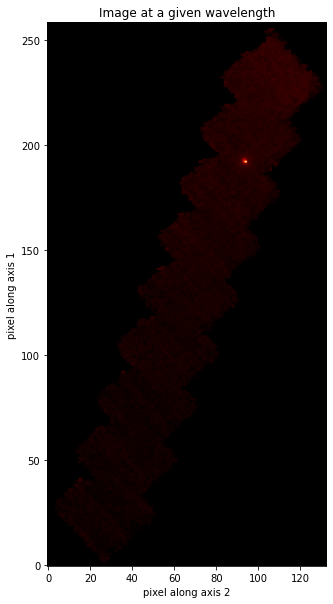

In [7]:
plt.figure(figsize=(20,10))
plt.imshow(cube_nirspec170_data[2], cmap='gist_heat', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.title('Image at a given wavelength')

The NIRSpec data contains several cubes over a  $ 13"\times \ 26"$ field of view, each one spanning over a $3" \times\  3"$ on the sky

### Mask to keep only the good pixels 
We want the PCA to run over only on the non-zeros pixels along the wavelength's axis. To do so, we create a mask that take into account only the data cubes along the diagonale. 

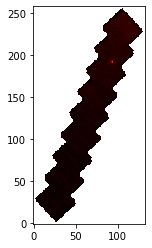

In [45]:

# My pedestrian way of doing things ----- Method 1 ---------
#for k in range(pix2):
#    image = np.array(cube_nirspec170_data[:][:,k])
#    for i in range(pix1):
#        if len(np.where(image[:,i]==0)[0]) == bands:
#            mask = 

# On Wilfried's suggestion, a more numpy-optimized method --------- Method 2 ---------
mask = ~np.all(cube_nirspec170_data==0, axis=0) # TRUE = good pixels; FALSE= bad pixels 
mask.shape # sanity check 

# To illustrate that our mask works, we display an image at a given wavelength 
data = cube_nirspec170_data[2].copy()
data[~mask]=np.nan

#plt.figure(figsize=(10,5))
plt.imshow(data, cmap='gist_heat', origin='lower')

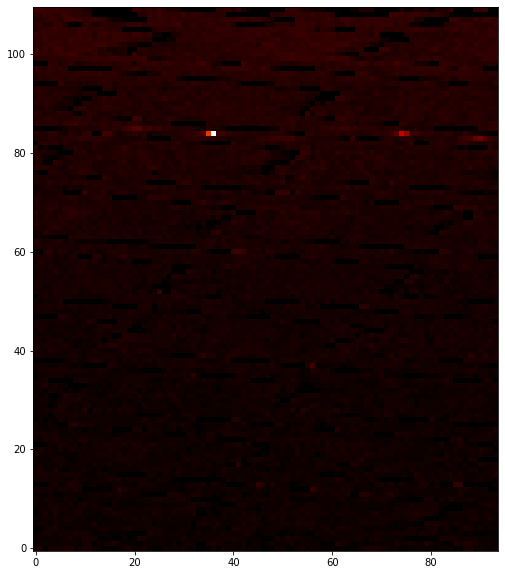

In [53]:
test = data[~np.isnan(data)]
test = test.reshape((110,94))
plt.figure(figsize=(25,10))
plt.imshow(test, cmap='gist_heat', origin='lower')

In [8]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [9]:
print(mask.shape)

(259, 133)


We reshape the data and apply the mask over the wavelengths

In [10]:
x, y  = np.arange(pix1), np.arange(pix2)
X, Y  = np.meshgrid(y, x)
output=[]
for x, y in zip(X[mask],Y[mask]):
        output.append(cube_nirspec170_data[:, y, x])

cubes2D = np.asarray(output)
print(X.shape)
print(Y.shape)
print(f'how X looks like:{X}')
print(f'how Y looks like:{Y}')


(259, 133)
(259, 133)
how X looks like:[[  0   1   2 ... 130 131 132]
 [  0   1   2 ... 130 131 132]
 [  0   1   2 ... 130 131 132]
 ...
 [  0   1   2 ... 130 131 132]
 [  0   1   2 ... 130 131 132]
 [  0   1   2 ... 130 131 132]]
how Y looks like:[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [256 256 256 ... 256 256 256]
 [257 257 257 ... 257 257 257]
 [258 258 258 ... 258 258 258]]


### PCA on the selected data cubes 
#### PCA based on covariance 

In [11]:
cubes2D.shape
#data = np.reshape(cube_nirspec170_data.copy(), (bands, pix1*pix2)).T #if we use the 1st method 

(10340, 3663)

In [45]:

#%time covariance_matrix=np.cov(cubes[:300].T)
%time covariance_matrix=np.cov(cubes2D.T)

CPU times: user 3.92 s, sys: 73.9 ms, total: 3.99 s
Wall time: 621 ms


In [46]:
%time eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

CPU times: user 1min 59s, sys: 661 ms, total: 2min
Wall time: 15.8 s


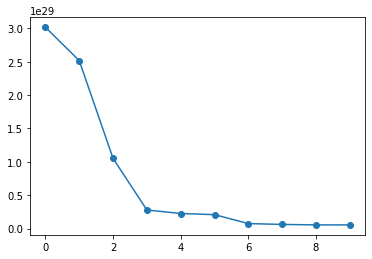

In [47]:
ind=np.arange(0,len(eigen_values),1)
ind=[x for _,x in sorted(zip(eigen_values,ind))]
ind=ind[::-1]
eigen_values1=eigen_values[ind] # sorted list in a decreasing order 
eigen_vectors1=eigen_vectors[:,ind]

eigen_values1=eigen_values1[:10]
x=np.arange(0,len(eigen_values1),1)
plt.plot(x,eigen_values1,marker = 'o')
plt.show()

#### PCA based on SVD

We implement a PCA through a *Single Value Decomposition* (SVD) **scipy.linalg**, allowing us to retrieve the projection of the data cubes onto the spectral subspace of reduced dimension. 


In [49]:
from sklearn.utils.extmath import svd_flip
from scipy import linalg


In [37]:
svd_flip?

Signature: svd_flip(u, v, u_based_decision=True)
Docstring:
Sign correction to ensure deterministic output from SVD.

Adjusts the columns of u and the rows of v such that the loadings in the
columns in u that are largest in absolute value are always positive.

Parameters
----------
u : ndarray
    u and v are the output of `linalg.svd` or
    :func:`~sklearn.utils.extmath.randomized_svd`, with matching inner
    dimensions so one can compute `np.dot(u * s, v)`.

v : ndarray
    u and v are the output of `linalg.svd` or
    :func:`~sklearn.utils.extmath.randomized_svd`, with matching inner
    dimensions so one can compute `np.dot(u * s, v)`.
    The input v should really be called vt to be consistent with scipy's
    output.

u_based_decision : bool, default=True
    If True, use the columns of u as the basis for sign flipping.
    Otherwise, use the rows of v. The choice of which variable to base the
    decision on is generally algorithm dependent.


Returns
-------
u_adjusted, v_adj

In [70]:
## From Claire's code 

def compute_pca(X, nb_comp): 
    """
    X       : a 2-D array of shape (number_pixels, L_h) where L_h is the number of spectral band 
    nb_comb : dimension of the spectral subspace, should be deduced from the decrease eigenvales plot 
    
    """
    #L, M = X.shape
    X_mean = np.mean(X, axis=0)
#    X_mean=np.zeros(M)
    X -= X_mean
    U, S, V = linalg.svd(X, full_matrices=False)
    U, V = svd_flip(U, V)
    S = S[:nb_comp]
#    Z=U[:,:nb_comp]*S
#    V=V[:nb_comp]
    Z = U[:, :nb_comp]*(S**(1/2))
    V = np.dot(np.diag(S**(1/2)), V[:nb_comp])
    return V.T, Z.T, X_mean


def pca_nirspec(Yns, nb_comp):
    """
    Yns     : spectral cube of shape (L_h, S_hx, S_hy) in which L_h represents the number of spectral bands and S_hx and S_hy the number of pixels along the 2 spatial axis 
    nb_comp : dimension of the spectral subspace, should be deduced from the decrease eigenvales plot
    
    returns the spectral projection of the cube on the spectral subspace Z along with the matrix of porjection V and a 2 dimensional centered cube X_mean of shape(L_h, S_hx * S_hy)
    
    """
    # Yns cube with L_h the spectral bands and S_hx & S_hy the spatials pixels
    L_h, S_hx, S_hy = Yns.shape
    X = np.reshape(Yns.copy(), (L_h, S_hx*S_hy)) # X depliage de Yns
    V, Z, X_mean = compute_pca(X.T, nb_comp)
    Z = np.reshape(Z, (nb_comp, S_hx, S_hy)) # replie le cube
    return V, Z, X_mean

def check_pca(V, Z, X_mean, Yns): 
    L, M, N = Z.shape
    Z = np.reshape(Z, (L, M*N))
    Yns = np.reshape(Yns, (Yns.shape[0], M*N))
    X = np.dot(V, Z)+np.matlib.repmat(X_mean, M*N, 1).T
    error = np.linalg.norm(Yns-X)/(L*M*N)
    return np.reshape(X, (Yns.shape[0], M, N)), error


In [54]:
new_cubes = []
for l in range(bands):
    image     = cube_nirspec170_data[l]
    image[~mask]=np.nan
    new_image = data[~np.isnan(data   )]
    new_image = new_image.reshape((110,94))
    new_cubes.append(new_image)
Yns = np.asarray(new_cubes)


In [66]:
nb_comp = 8
V, Z, X_mean = pca_nirspec(Yns, nb_comp) 

In [55]:
Yns.shape

(3663, 110, 94)

In [57]:
Z.shape

(8, 110, 94)

Text(0.5, 1.0, 'Image at a given wavelength')

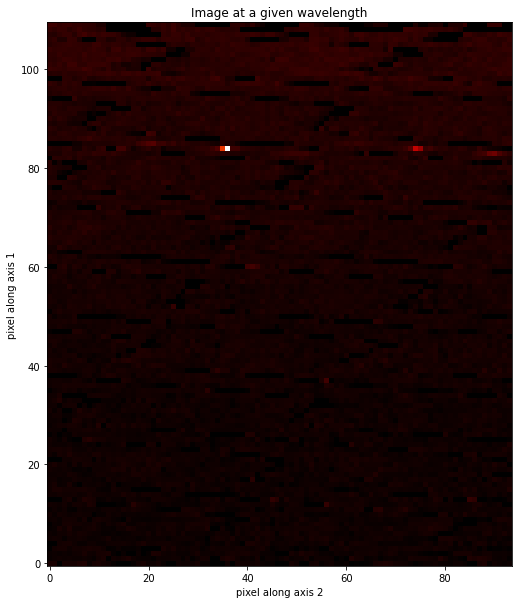

In [65]:
plt.figure(figsize=(20,10))
plt.imshow(Z[0], cmap='gist_heat', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.title('Image at a given wavelength')

In [83]:
_, error = check_pca(V,Z,X_mean, Yns)
print(error)

3889.6738878143133


In [75]:
np.matlib?

Type:        module
String form: <module 'numpy.matlib' from '/Users/lina/opt/anaconda3/lib/python3.9/site-packages/numpy/matlib.py'>
File:        ~/opt/anaconda3/lib/python3.9/site-packages/numpy/matlib.py
Docstring:   <no docstring>
